In [1]:
# importo tutti i vari moduli di Python
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
        #pyplot serve per generare le figure
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
# from ... import ... così non devo mettere nessun prefisso 
# ogni volta che vado a richiamare il pacchetto importato
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.5.0


In [3]:
from IPython.display import display, clear_output
import PIL
def animate_solution(images, timestamps=None):
    def animate(i):
        changed_artifacts = [im]
        im.set_data(images[i])
        if timestamps is not None:
            time_text.set_text(timestamps[i])
            changed_artifacts.append(im)
        return tuple(changed_artifacts)

    
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    if timestamps is not None:
        time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes)

    anim = animation.FuncAnimation(fig, animate, frames=len(images), interval=60, blit=True)
    
    # To prevent plotting image inline.
    plt.close()
    return anim

In [4]:
# RASTERIZER CLASS

In [5]:
os.environ["L5KIT_DATA_FOLDER"] = "/Users/Alberto/Documents/AAB Documents/Python prova/Dataset"
cfg=load_config_data("/Users/Alberto/Documents/AAB Documents/Python prova/Dataset/visualisation_config.yaml")
#cfg non è altro che il contenuto del file visualization_config.yaml
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}


In [6]:
dm = LocalDataManager()
#Ci dice che i dati che ci servono sono all’interno di una cartella specifica.
dataset_path = dm.require('/Users/Alberto/Documents/AAB Documents/Python prova/Dataset/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
#ChunkedDataset is a dataset that lives on disk in compressed chunks, 
#it has easy to use data loading and writing interfaces that involves making numpy-like slices. 
#Currently only .zarr directory stores are supported 
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
def visualize_rgb_image(dataset, index, title="", ax=None):
    """Visualizes Rasterizer's RGB image"""
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)

    if ax is None:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.imshow(im[::-1])

In [8]:
rasterizer_dict = {}
dataset_dict={}

#rasterizer_dict è composto dalla lista di parametri di rasterizer_type_list.
#Come tipologia di file è un file dict (insieme di valori key)
rasterizer_type_list = ["stub_debug", "satellite_debug", "semantic_debug", "box_debug", "py_satellite", "py_semantic"]

for i, key in enumerate(rasterizer_type_list):
    print(str(i) + '   ' + key)
    cfg["raster_params"]["map_type"] = key
    rasterizer_dict[key] = build_rasterizer(cfg, dm)
    dataset_dict[key] = EgoDataset(cfg, zarr_dataset, rasterizer_dict[key])
    
#noto che all'inizio rasterizer_dict e dataset_dict sono stati inseriti come insiemi vuoti {}
#durante il ciclo if i loro valori vengono aggiornati ad ogni iterazione

0   stub_debug
1   satellite_debug
2   semantic_debug
3   box_debug
4   py_satellite
5   py_semantic


In [9]:
# DEFINISCO FRAME
#cambiando index cambia IL FRAME visualizzato
#nell'esempio i FRAME sono 24838. Il vengono numerati a partire dallo 0
#quindi posso visualizzare i frame dal numero 0 al numero 24837.

frame_idx=0
print(frame_idx, type(frame_idx))

0 <class 'int'>


In [10]:
#DEFINISCO SCENA
#cambiando scene_idx cambia LA SCENA visualizzata
#nell'esempio le SCENE sono 100. 

scene_idx = 0
print(scene_idx, type(scene_idx))

0 <class 'int'>


0   stub_debug
1   satellite_debug
2   semantic_debug
3   box_debug
4   py_satellite
5   py_semantic


/var/folders/5r/4hgfmgmd0wj4bmfwt33twxxm0000gn/T/ipykernel_2627/2354610784.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



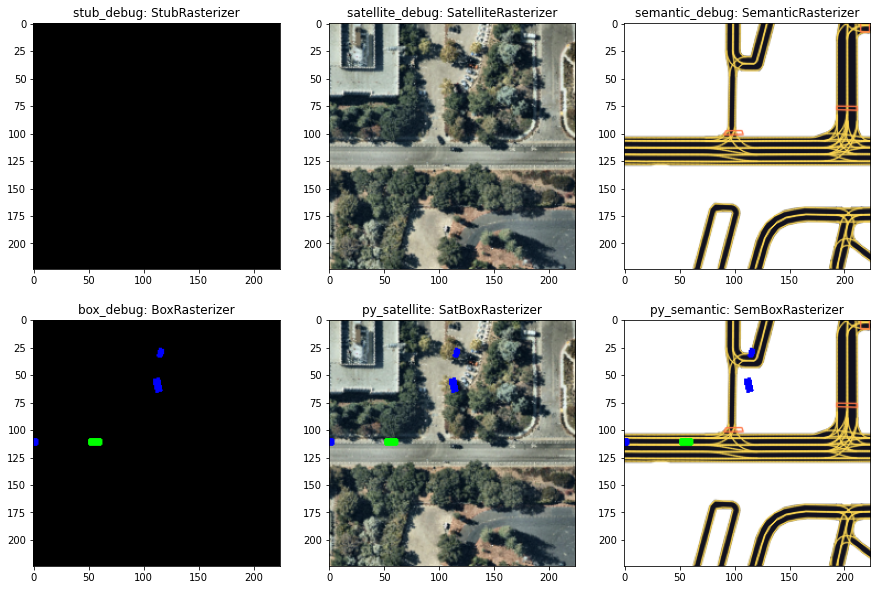

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, key in enumerate(rasterizer_type_list):
    print(str(i) + '   ' + key)
    visualize_rgb_image(dataset_dict[key], frame_idx, title=f"{key}: {type(rasterizer_dict[key]).__name__}", ax=axes[i])
    fig.show()

In [12]:
def create_animate_for_indexes(dataset, indexes):
    images = []
    timestamps = []

    for idx in indexes:
        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
        clear_output(wait=True)
        images.append(PIL.Image.fromarray(im[::-1]))
        timestamps.append(data["timestamp"])

    anim = animate_solution(images, timestamps)
    return anim

def create_animate_for_scene(dataset, scene_idx):
    indexes = dataset.get_scene_indices(scene_idx)
    return create_animate_for_indexes(dataset, indexes)

In [13]:
#MANCA LA CELLA IN CUI VISUALIZZO UNA SCENA INTERA (una scena è l'insieme di più fotogrammi)
#CI SONO SICURAMENTE PROBLEMI CON LA VARIABILE 'dataset'

dataset = dataset_dict['py_semantic']
#anim = create_animate_for_indexes(dataset, scene_idx)
print("scene_idx", scene_idx)
#HTML(anim.to_jshtml())

scene_idx 0


In [14]:
# EGO DATASET

In [15]:
semantic_rasterizer = rasterizer_dict["py_semantic"]
dataset = dataset_dict["py_semantic"]

In [16]:
# punto in cui finisce una scena e ne comincia un'altra
print("Lunghezza cumulata delle scene", dataset.cumulative_sizes)

# lunghezza di una scena
print("Lunghezza di ogni scena in frames", dataset.cumulative_sizes[1:] - dataset.cumulative_sizes[:-1])
#noto che la lunghezza di ogni scena si aggira attorno ai 248/249 frames

Lunghezza cumulata delle scene [  248   497   746   995  1244  1493  1742  1991  2240  2489  2738  2987
  3236  3485  3734  3983  4232  4481  4730  4979  5228  5477  5725  5973
  6221  6469  6717  6965  7213  7461  7709  7957  8205  8453  8701  8949
  9197  9445  9693  9941 10189 10437 10685 10933 11182 11431 11680 11929
 12177 12425 12673 12921 13169 13417 13665 13913 14161 14409 14657 14905
 15153 15401 15649 15897 16145 16393 16641 16889 17137 17385 17633 17881
 18129 18377 18625 18874 19123 19372 19621 19870 20118 20366 20614 20862
 21110 21358 21607 21856 22105 22354 22603 22852 23101 23350 23598 23846
 24094 24342 24590 24838]
Lunghezza di ogni scena in frames [249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249
 249 249 249 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248
 248 248 248 248 248 248 248 249 249 249 249 248 248 248 248 248 248 248
 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248 248
 248 248 249 249 249 249 249 248 

In [17]:
# il frame di riferimento è l'attributo frame_idx definito prima
data = dataset[frame_idx]

print("ego dataset[", frame_idx,"]=data is ", type(data))

def _describe(value):
    if hasattr(value, "shape"):
        return f"{type(value).__name__:20} shape={value.shape}"
    else:
        return f"{type(value).__name__:20} value={value}"

for key, value in data.items():
    print("  ", f"{key:25}", _describe(value))
    
# dalle cose stampate vedo che il frame (frame_frame_idx) entra all'interno
# di una data scena (scene_frame_idx)

ego dataset[ 0 ]=data is  <class 'dict'>
   frame_index               int                  value=0
   image                     ndarray              shape=(5, 224, 224)
   target_positions          ndarray              shape=(50, 2)
   target_yaws               ndarray              shape=(50, 1)
   target_velocities         ndarray              shape=(50, 2)
   target_availabilities     ndarray              shape=(50,)
   history_positions         ndarray              shape=(1, 2)
   history_yaws              ndarray              shape=(1, 1)
   history_velocities        ndarray              shape=(0, 2)
   history_availabilities    ndarray              shape=(1,)
   world_to_image            ndarray              shape=(3, 3)
   raster_from_agent         ndarray              shape=(3, 3)
   raster_from_world         ndarray              shape=(3, 3)
   agent_from_world          ndarray              shape=(3, 3)
   world_from_agent          ndarray              shape=(3, 3)
   centroid 

In [18]:
frame_indices = dataset.get_scene_indices(scene_idx)
print(f"frame_indices for scene {scene_idx} = {frame_indices}")

scene_dataset = dataset.get_scene_dataset(scene_idx)
print(f"scene_dataset {type(scene_dataset).__name__}, length {len(scene_dataset)}")

# Animate whole "scene_dataset"
#create_animate_for_indexes(scene_dataset, np.arange(len(scene_dataset)))

frame_indices for scene 0 = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 23

/usr/local/Cellar/jupyterlab/3.1.14_1/libexec/lib/python3.9/site-packages/l5kit/data/zarr_dataset.py:213: RuntimeWarning:

zarr dataset path should end with .zarr (for now). Open will fail for this dataset!



In [19]:
# AGENT DATASET

In [20]:
semantic_rasterizer = rasterizer_dict["py_semantic"]
agent_dataset = AgentDataset(cfg, zarr_dataset, semantic_rasterizer)

In [21]:
# The returned data structure is same.
# il frame di riferimento è l'attributo frame_idx definito prima
data = agent_dataset[frame_idx]

print("agent dataset[", frame_idx,"]=data is ", type(data))

def _describe(value):
    if hasattr(value, "shape"):
        return f"{type(value).__name__:20} shape={value.shape}"
    else:
        return f"{type(value).__name__:20} value={value}"

for key, value in data.items():
    print("  ", f"{key:25}", _describe(value))

agent dataset[ 0 ]=data is  <class 'dict'>
   frame_index               int                  value=11
   image                     ndarray              shape=(5, 224, 224)
   target_positions          ndarray              shape=(50, 2)
   target_yaws               ndarray              shape=(50, 1)
   target_velocities         ndarray              shape=(50, 2)
   target_availabilities     ndarray              shape=(50,)
   history_positions         ndarray              shape=(1, 2)
   history_yaws              ndarray              shape=(1, 1)
   history_velocities        ndarray              shape=(0, 2)
   history_availabilities    ndarray              shape=(1,)
   world_to_image            ndarray              shape=(3, 3)
   raster_from_agent         ndarray              shape=(3, 3)
   raster_from_world         ndarray              shape=(3, 3)
   agent_from_world          ndarray              shape=(3, 3)
   world_from_agent          ndarray              shape=(3, 3)
   centro

In [22]:
frame_indices = agent_dataset.get_scene_indices(scene_idx)
print(f"frame_indices for scene {scene_idx} = {frame_indices}")

scene_dataset = agent_dataset.get_scene_dataset(scene_idx)
print(f"scene_dataset {type(scene_dataset).__name__}, length {len(scene_dataset)}")

# Animate whole "scene_dataset"
#create_animate_for_indexes(scene_dataset, np.arange(len(scene_dataset)))

frame_indices for scene 0 = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
scene_dataset AgentDataset, length 35


/usr/local/Cellar/jupyterlab/3.1.14_1/libexec/lib/python3.9/site-packages/l5kit/dataset/agent.py:139: RuntimeWarning:

you're running with a custom agents_mask



In [25]:
for i in range(150):
    print(i, agent_dataset.get_frame_indices(i))

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 [0]
12 [1]
13 [2]
14 [3]
15 [4]
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 [5]
68 [6]
69 [7]
70 [8]
71 [9]
72 [10]
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 [11]
103 [12]
104 [13]
105 [14]
106 [15]
107 [16]
108 [17]
109 [18]
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 []
133 []
134 []
135 []
136 []
137 []
138 []
139 []
140 []
141 []
142 []
143 []
144 []
145 []
146 []
147 []
148 []
149 []


timestamp = 1572643685901838786
timestamp = 1572643685901838786


/var/folders/5r/4hgfmgmd0wj4bmfwt33twxxm0000gn/T/ipykernel_2627/4091656649.py:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



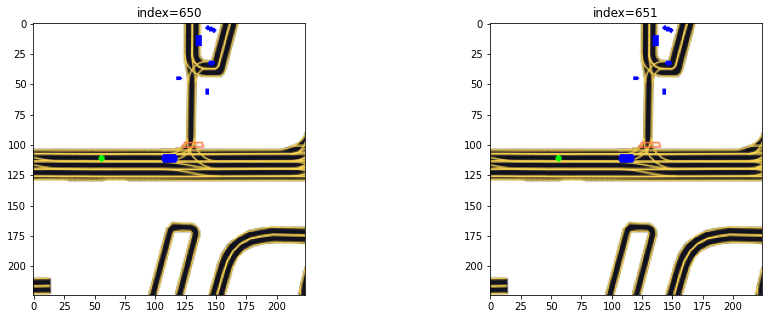

In [24]:
#il numero tra parentesi è l'attributo "i" definito nella cella precedente
#le immagini visualizzate sono i frame (attributo tra parentesi quadra [] nell'output della cella precedente)
frame_indices = agent_dataset.get_frame_indices(815)

fig, axes = plt.subplots(1, len(frame_indices), figsize=(15, 5))
axes = axes.flatten()

for i in range(len(frame_indices)):
    index = frame_indices[i]
    t = agent_dataset[frame_idx]["timestamp"]
    # Timestamp is same for same frame.
    print(f"timestamp = {t}")
    visualize_rgb_image(agent_dataset, index=frame_idx, title=f"index={index}", ax=axes[i])
fig.show()

#Lo stesso fotogramma contiene più agenti, quindi contiene più fotogrammi uguali.
#Fotogrammi senza agenti non vengono visualizzati
#Il ritorno di EgoDataset era banale, ma AgentDataset 
#può restituire più indici poiché esistono diversi agenti in ogni frame